In [1]:
import arviz as az
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
from scipy.special import erf

az.rcParams["plot.max_subplots"] = 80

First, load the output of our inference as an arviz InferenceData object:

In [2]:
#data = az.from_netcdf("ar_z_tmp.cdf")
data = az.from_netcdf("/Volumes/LaCie/cca/autoregressive-bbh-inference-data/final-ar_z.cdf")
az.summary(data,["ar_z_std",
                 "ar_z_tau",
                 "logR20",
                 "alpha",
                 "mMin",
                 "log_dmMin",
                 "mu_m1",
                 "sig_m1",
                 "log_f_peak",
                 "mMax",
                 "log_dmMax",
                 "bq",
                 "mu_chi",
                 "logsig_chi",
                 "sig_cost",
                 "nEff_inj_per_event",
                 "min_log_neff"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ar_z_std,0.977,0.525,0.015,1.878,0.012,0.009,1629.0,1285.0,1.0
ar_z_tau,0.963,0.348,0.370,1.500,0.005,0.003,5276.0,2735.0,1.0
logR20,-0.337,0.429,-1.121,0.592,0.011,0.007,2130.0,1124.0,1.0
alpha,-3.749,0.359,-4.412,-3.070,0.007,0.005,2386.0,2090.0,1.0
mMin,9.192,0.907,7.499,10.993,0.019,0.014,2710.0,1843.0,1.0
log_dmMin,-0.417,0.368,-1.000,0.183,0.007,0.005,2600.0,1960.0,1.0
mu_m1,33.934,2.039,30.093,37.326,0.060,0.042,2020.0,1000.0,1.0
sig_m1,4.182,2.197,2.000,8.440,0.063,0.049,1966.0,1137.0,1.0
log_f_peak,-2.592,0.269,-3.000,-2.134,0.005,0.003,2827.0,2339.0,1.0
mMax,78.489,12.900,56.480,99.992,0.190,0.135,4066.0,2373.0,1.0


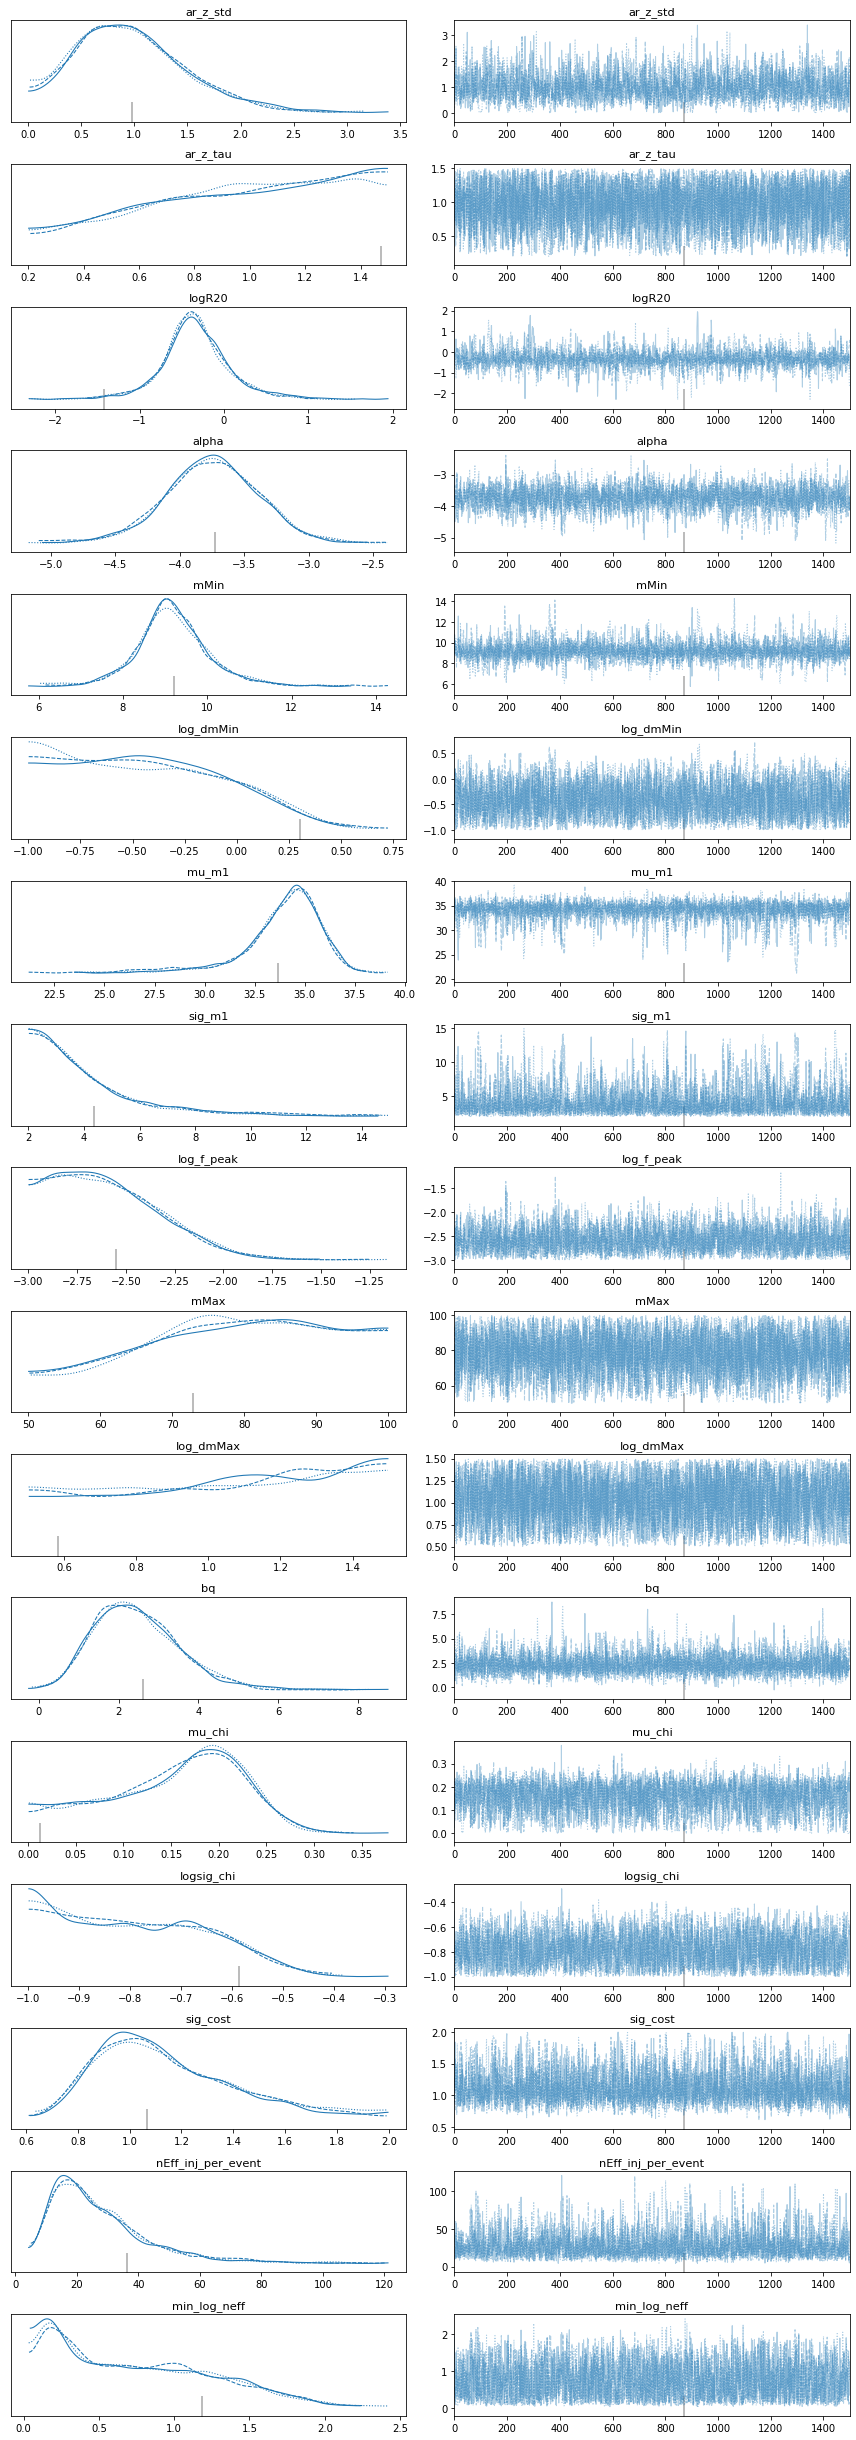

In [3]:
az.plot_trace(data,
              ["ar_z_std",
                 "ar_z_tau",
                 "logR20",
                 "alpha",
                 "mMin",
                 "log_dmMin",
                 "mu_m1",
                 "sig_m1",
                 "log_f_peak",
                 "mMax",
                 "log_dmMax",
                 "bq",
                 "mu_chi",
                 "logsig_chi",
                 "sig_cost",
                 "nEff_inj_per_event",
                 "min_log_neff"], compact=True)
plt.tight_layout()
plt.show()

In [ ]:
#z_data = np.load('ar_z_data_tmp.npy',allow_pickle=True)[()]
z_data = np.load('/Volumes/LaCie/cca/autoregressive-bbh-inference-data/final-ar_z_data.npy',allow_pickle=True)[()]
z_values = z_data['z_allSamples']
samps = data.posterior.stack(draws=("chain", "draw"))

In [13]:
logR20s = az.extract(data,var_names=["logR20"])
mu = np.mean(logR20s.values)
std = np.std(logR20s.values)
print(mu,std)

-0.3371147826127904 0.429252423072362


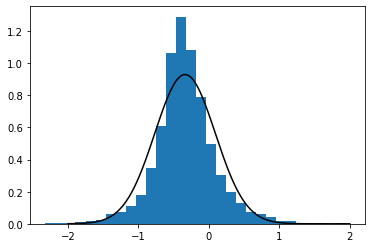

In [12]:
fig,ax = plt.subplots()
ax.hist(logR20s.values,density=True,bins=30)

xs = np.linspace(-2,2,1000)
ys = np.exp(-(xs-mu)**2/(2.*std**2))/np.sqrt(2.*np.pi*std**2)
ax.plot(xs,ys,color='black')

plt.show()

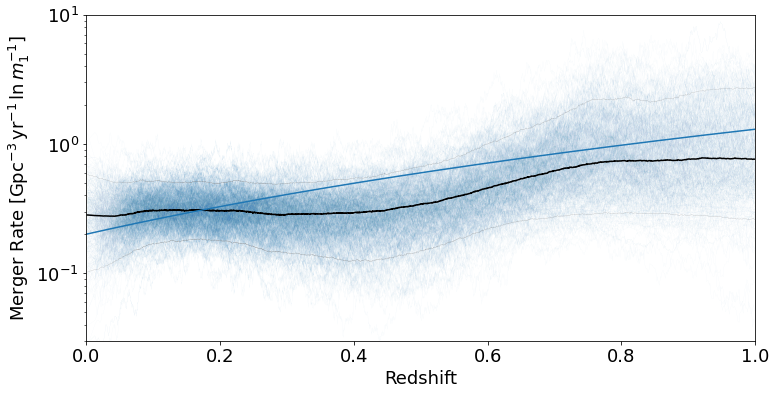

In [5]:
reduced_zs = z_values[::50]
reduced_f_zs = samps['f_zs'][::50]

R_zs = np.zeros((reduced_zs.size,reduced_f_zs.shape[1]))
for i in range(reduced_f_zs.shape[1]):
    R_zs[:,i] = samps.R20[i]*reduced_f_zs[:,i]#*(1.+reduced_zs)**samps.kappa.values[i]/(1.+0.2)**samps.kappa.values[i]

fig,ax = plt.subplots(figsize=(12,6))
for i in np.random.choice(range(reduced_f_zs.shape[1]),500):
    ax.plot(reduced_zs,R_zs[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

ax.plot(reduced_zs,np.median(R_zs,axis=1),color='black')
ax.plot(reduced_zs,np.quantile(R_zs,0.05,axis=1),color='grey',lw=0.15)
ax.plot(reduced_zs,np.quantile(R_zs,0.95,axis=1),color='grey',lw=0.15)

zs = np.linspace(0,1.3,300)
ax.plot(zs,0.2*(1.+zs)**2.7)

ax.tick_params(labelsize=18)
ax.set_xlim(0,1)
ax.set_ylim(3e-2,10)
ax.set_yscale('log')

#ax.set_xticks([10,30,100])
#ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_xlabel('Redshift',fontsize=18)
ax.set_ylabel('Merger Rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]',fontsize=18)

plt.show()

In [6]:
data_alt = az.from_netcdf("/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_z_comparisonTest_variableKappa.cdf")
samps_alt = data_alt.posterior.stack(draws=("chain", "draw"))

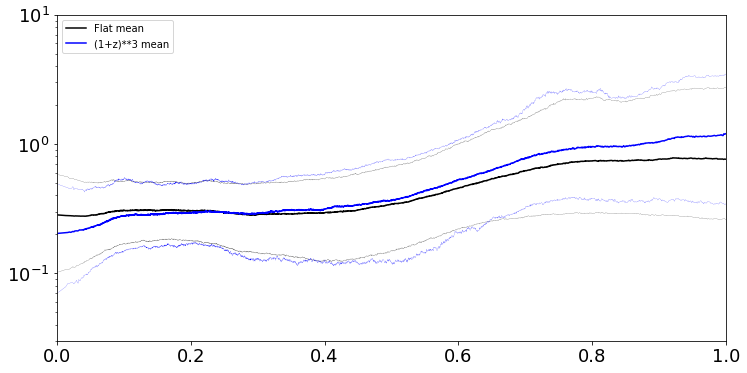

In [7]:
#data_alt = az.from_netcdf("ar_z_tmp.cdf")
#samps_alt = data_alt.posterior.stack(draws=("chain", "draw"))

z_data_alt = np.load('/mnt/ceph/users/tcallister/autoregressive-bbh-inference-data/ar_z_data_comparisonTest_variableKappa.npy',allow_pickle=True)[()]
z_values_alt = z_data_alt['z_allSamples']

reduced_zs_alt = z_values_alt[::50]
reduced_f_zs_alt = samps_alt['f_zs'][::50]

R_zs_alt = np.zeros((reduced_zs_alt.size,reduced_f_zs_alt.shape[1]))
for i in range(reduced_f_zs_alt.shape[1]):
    R_zs_alt[:,i] = samps_alt.R20[i]*reduced_f_zs_alt[:,i]*(1.+reduced_zs_alt)**samps_alt.kappa.values[i]/(1.+0.2)**samps_alt.kappa.values[i]
    
fig,ax = plt.subplots(figsize=(12,6))

ax.plot(reduced_zs,np.median(R_zs,axis=1),color='black',label='Flat mean')
ax.plot(reduced_zs,np.quantile(R_zs,0.05,axis=1),color='black',lw=0.15)
ax.plot(reduced_zs,np.quantile(R_zs,0.95,axis=1),color='black',lw=0.15)

ax.plot(reduced_zs_alt,np.median(R_zs_alt,axis=1),color='blue',label='(1+z)**3 mean')
ax.plot(reduced_zs_alt,np.quantile(R_zs_alt,0.05,axis=1),color='blue',lw=0.15)
ax.plot(reduced_zs_alt,np.quantile(R_zs_alt,0.95,axis=1),color='blue',lw=0.15)

#zs = np.linspace(0,1.3,300)
#ax.plot(zs,0.2*(1.+zs)**2.7)

ax.legend(loc='upper left')

ax.tick_params(labelsize=18)
ax.set_xlim(0,1.)
ax.set_ylim(3e-2,10)
ax.set_yscale('log')

(array([ 1.,  1.,  0.,  2.,  1.,  3.,  2.,  3.,  8.,  9., 10., 10., 12.,
         9., 11., 16., 16., 15., 15., 12., 13.,  7.,  7.,  4.,  4.,  4.,
         1.,  2.,  1.,  1.]),
 array([-4.72177809, -4.65684816, -4.59191822, -4.52698829, -4.46205836,
        -4.39712843, -4.33219849, -4.26726856, -4.20233863, -4.1374087 ,
        -4.07247877, -4.00754883, -3.9426189 , -3.87768897, -3.81275904,
        -3.7478291 , -3.68289917, -3.61796924, -3.55303931, -3.48810937,
        -3.42317944, -3.35824951, -3.29331958, -3.22838964, -3.16345971,
        -3.09852978, -3.03359985, -2.96866991, -2.90373998, -2.83881005,
        -2.77388012]),
 <BarContainer object of 30 artists>)

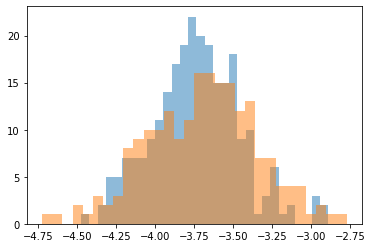

In [11]:
fig,ax = plt.subplots()

ax.hist(samps['alpha'].values,bins=30,alpha=0.5)
ax.hist(samps_alt['alpha'].values,bins=30,alpha=0.5)

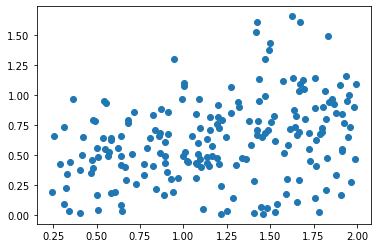

In [9]:
tau = samps['ar_z_tau']
std = samps['ar_z_std']
fig,ax = plt.subplots()
ax.scatter(tau,std)

In [ ]:
reduced_zs = z_values[::50]
reduced_f_zs = samps['f_zs'][::50,tau<1]

R_zs = np.zeros((reduced_zs.size,reduced_f_zs.shape[1]))
for i in range(reduced_f_zs.shape[1]):
    R_zs[:,i] = samps.R20[i]*reduced_f_zs[:,i]

fig,ax = plt.subplots(figsize=(14,6))
for i in np.random.choice(range(reduced_f_zs.shape[1]),500):
    ax.plot(reduced_zs,R_zs[:,i],color='#3182bd',alpha=0.1,lw=0.1,zorder=0)

ax.plot(reduced_zs,np.median(R_zs,axis=1),color='black')
ax.plot(reduced_zs,np.quantile(R_zs,0.05,axis=1),color='grey',lw=0.15)
ax.plot(reduced_zs,np.quantile(R_zs,0.95,axis=1),color='grey',lw=0.15)

zs = np.linspace(0,1.3,300)
ax.plot(zs,0.2*(1.+zs)**2.7)

ax.tick_params(labelsize=18)
ax.set_xlim(0,1.25)
ax.set_ylim(3e-2,10)
#ax.set_xscale('log')
ax.set_yscale('log')

#ax.set_xticks([10,30,100])
#ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_xlabel('Redshift',fontsize=18)
ax.set_ylabel('Merger Rate [$\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,\ln m_1^{-1}$]',fontsize=18)

plt.show()

In [7]:
ratios = np.zeros(reduced_f_zs.shape[1])
for i in range(reduced_f_zs.shape[1]):
    
    R02 = np.interp(0.2,reduced_zs,reduced_f_zs[:,i])
    R08 = np.interp(0.8,reduced_zs,reduced_f_zs[:,i])
    ratios[i] = R08/R02

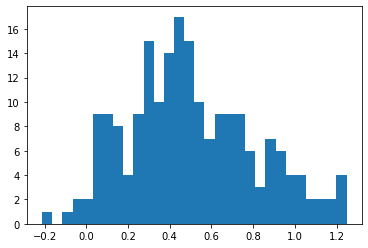

In [8]:
fig,ax = plt.subplots()
ax.hist(np.log10(ratios),bins=30)
plt.show()

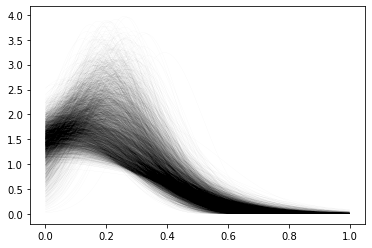

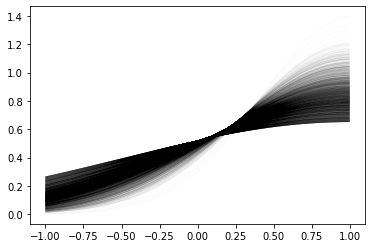

In [9]:
def gaussian(samples,mu,sigma,lowCutoff,highCutoff):
    
    """
    Function defining the probability density due to a truncated Gaussian
    """
    
    a = (lowCutoff-mu)/np.sqrt(2*sigma**2)
    b = (highCutoff-mu)/np.sqrt(2*sigma**2)
    norm = np.sqrt(sigma**2*np.pi/2)*(-erf(a) + erf(b))
    return np.exp(-(samples-mu)**2/(2.*sigma**2))/norm

fig,ax = plt.subplots()
grid = np.linspace(0,1,1000)
for i in range(samps.mu_chi.size):
    
    p_chi = gaussian(grid,samps.mu_chi.values[i],10.**samps.logsig_chi.values[i],-1,1)
    ax.plot(grid,p_chi,color='black',lw=0.1,alpha=0.1)
plt.show()

fig,ax = plt.subplots()
grid = np.linspace(-1,1,1000)
for i in range(samps.mu_chi.size):
    
    #p_cost = gaussian(grid,samps.mu_cost.values[i],samps.sig_cost.values[i],-1,1)
    p_cost = gaussian(grid,1.,samps.sig_cost.values[i],-1,1)

    ax.plot(grid,p_cost,color='black',lw=0.1,alpha=0.1)
plt.show()